In [1]:
import numpy as np
import codecs
import argparse
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from nltk import Tree
import random
import math
import subprocess
import sys
from collections import deque, Counter, defaultdict
from scipy.sparse.csgraph import minimum_spanning_tree
import string

%matplotlib inline

In [5]:
attention_file = '../data/experiments/ende-16h-bpe100k/attentions.npz'
token_file = '../data/experiments/ende-16h-bpe100k/source.txt'

maxlen = 1000

fontsize=8

#this is necessary in this case
eos =True

In [6]:
def aggregate_subtoken_matrix(attention_matrix, wordpieces):
    # this functions connects subtokens and aggregates their attention.
    aggregate_wps = []
    wp_ids = []
    for wp_id, wp in enumerate(wordpieces):
        wp_ids.append(wp_id)
        if not wp.endswith('@@'):
            aggregate_wps.append(wp_ids)
            wp_ids = []

    midres_matrix = np.zeros((len(aggregate_wps), len(wordpieces)))

    for tok_id, wp_ids in enumerate(aggregate_wps):
        midres_matrix[tok_id,: ] = np.mean(attention_matrix[wp_ids, :], axis=0)

    res_matrix = np.zeros((len(aggregate_wps), len(aggregate_wps)))

    for tok_id, wp_ids in enumerate(aggregate_wps):
        res_matrix[:, tok_id] = np.sum(midres_matrix[:, wp_ids], axis=1)

    words = ' '.join(wordpieces).replace('@@ ', '')
    res_tokens = words.split()

    assert len(res_tokens) == len(aggregate_wps), "Result matrix and token dimesnions don't match"
    return res_matrix

# recursively aggregated -- attention over input tokens
def wm_aggreg(this_layer, last_layer):
    return (np.matmul(this_layer, last_layer) + last_layer) / 2

# this layer and residual connection -- attention over positions
def wm_avg(this_layer, first_layer):
    return (this_layer + first_layer) / 2

In [7]:
attentions_loaded = np.load(attention_file)
sentences_count = 300
layers_count = attentions_loaded['arr_0'].shape[0]
heads_count = attentions_loaded['arr_0'].shape[1]


viss = dict()
word_mixtures = dict()
words_lists = dict()
with open(token_file) as tokens_file:
    tokens_loaded = [l.split() for l in tokens_file]

for sentence_index in range(sentences_count):

    sentence_id = 'arr_' + str(sentence_index)
    tokens_count = attentions_loaded[sentence_id].shape[2]
    if eos:
        tokens_count -= 1
    tokens_list = tokens_loaded[sentence_index]

    # check maxlen
    words = ' '.join(tokens_list).replace('@@ ', '')

    words_list = words.split()
    if len(words_list) <= maxlen:
        print('Processing sentence', sentence_index, file=sys.stderr)

    # NOTE sentences truncated to 64 tokens
    # assert len(tokens_list) == tokens_count, "Bad no of tokens in sent " + str(sentence_index)
    assert len(tokens_list) >= tokens_count, "Bad no of tokens in sent " + str(sentence_index)
    if len(tokens_list) > tokens_count:
        print('Too long sentence, skipped', sentence_index, file=sys.stderr)
        continue
    #     TRUNCATED = True
    #     print('Truncating tokens from ', len(tokens_list), 'to', tokens_count,
    #           'on line', sentence_index, '(0-based indexing)', file=sys.stderr)
    #     tokens_list = tokens_list[:tokens_count]
    # else:
    #     TRUNCATED = False

    words_count = len(words_list)

    # for visualisation -- vis[layer][aggreg][head]
    word_mixture = list() 
    word_mixture.append(np.identity(words_count))
    # for visualisation -- vis[layer][aggreg][head]
    vis = list()

    for layer in range(layers_count):
        layer_deps = list()  # for vis
        layer_matrix = np.zeros((words_count, words_count))
        for head in range(heads_count):
            matrix = attentions_loaded[sentence_id][layer][head]
            if eos:
                matrix = matrix[:-1, :-1]
            # the max trick -- for each row subtract its max
            # from all of its components to get the values into (-inf, 0]
            matrix = matrix - np.max(matrix, axis=1, keepdims=True)
            # softmax
            exp_matrix = np.exp(matrix)
            deps = exp_matrix/ np.sum(exp_matrix, axis=1, keepdims=True)
            deps = aggregate_subtoken_matrix(deps, tokens_list)
            layer_deps.append(deps)
            layer_matrix = layer_matrix + deps
            layer_matrix = layer_matrix / heads_count
        layer_deps.append(layer_matrix)
    
        # next layer = avg of this layer and prev layer
        # TODO add head weights from ff matrices
        vis.append([
                layer_deps,
                [wm_aggreg(m, word_mixture[layer]) for m in layer_deps],
                ])
        word_mixture.append( wm_aggreg(layer_matrix, word_mixture[layer]) )
    viss[sentence_index] = vis
    word_mixtures[sentence_index] = word_mixture
    words_lists[sentence_index] = words_list

Processing sentence 0
Processing sentence 1
Processing sentence 2
Processing sentence 3
Processing sentence 4
Processing sentence 5
Processing sentence 6
Processing sentence 7
Processing sentence 8
Processing sentence 9
Processing sentence 10
Processing sentence 11
Processing sentence 12
Processing sentence 13
Processing sentence 14
Processing sentence 15
Processing sentence 16
Processing sentence 17
Processing sentence 18
Processing sentence 19
Processing sentence 20
Processing sentence 21
Processing sentence 22
Processing sentence 23
Processing sentence 24
Processing sentence 25
Processing sentence 26
Processing sentence 27
Processing sentence 28
Processing sentence 29
Processing sentence 30
Processing sentence 31
Processing sentence 32
Processing sentence 33
Processing sentence 34
Processing sentence 35
Too long sentence, skipped 35
Processing sentence 36
Processing sentence 37
Processing sentence 38
Processing sentence 39
Processing sentence 40
Processing sentence 41
Processing sen

In [21]:
def plot_head(viss,words_lists, l, h):

    choices = np.random.choice(list(viss.keys()), 9)
    fig, axes = plt.subplots(3,3,figsize=(18,18))
    for  ch, ax in zip(choices, axes.ravel()):
        im = ax.imshow(viss[ch][l][0][h],cmap='Blues')
        ax.set_xticks(np.arange(len(words_lists[ch])))
        ax.set_yticks(np.arange(len(words_lists[ch])))
        ax.set_xticklabels(words_lists[ch], rotation=45)
        ax.set_yticklabels(words_lists[ch])
    plt.show()

# HEAD L5H0 - versatile

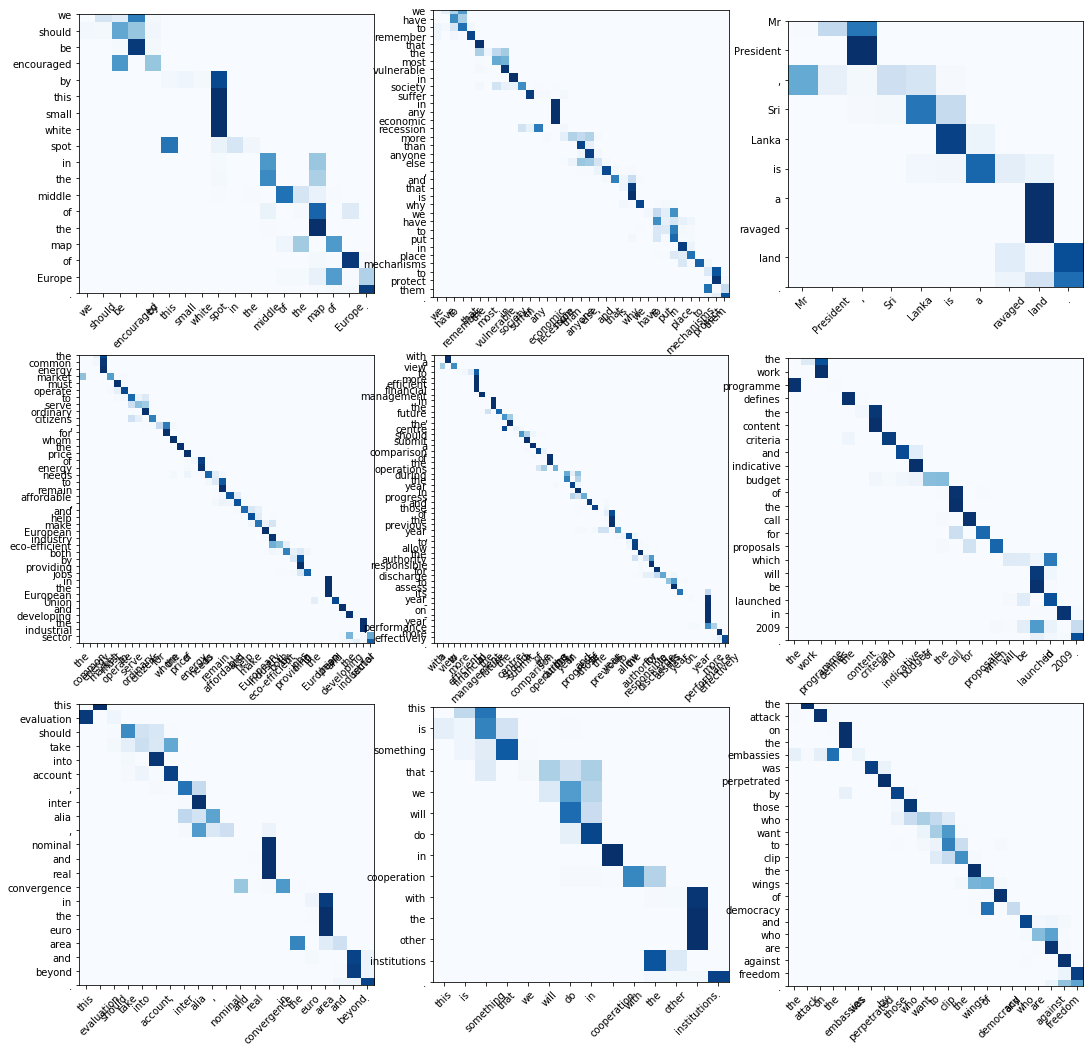

In [22]:
plot_head(viss,words_lists, 5, 0)

# L4H9 subject

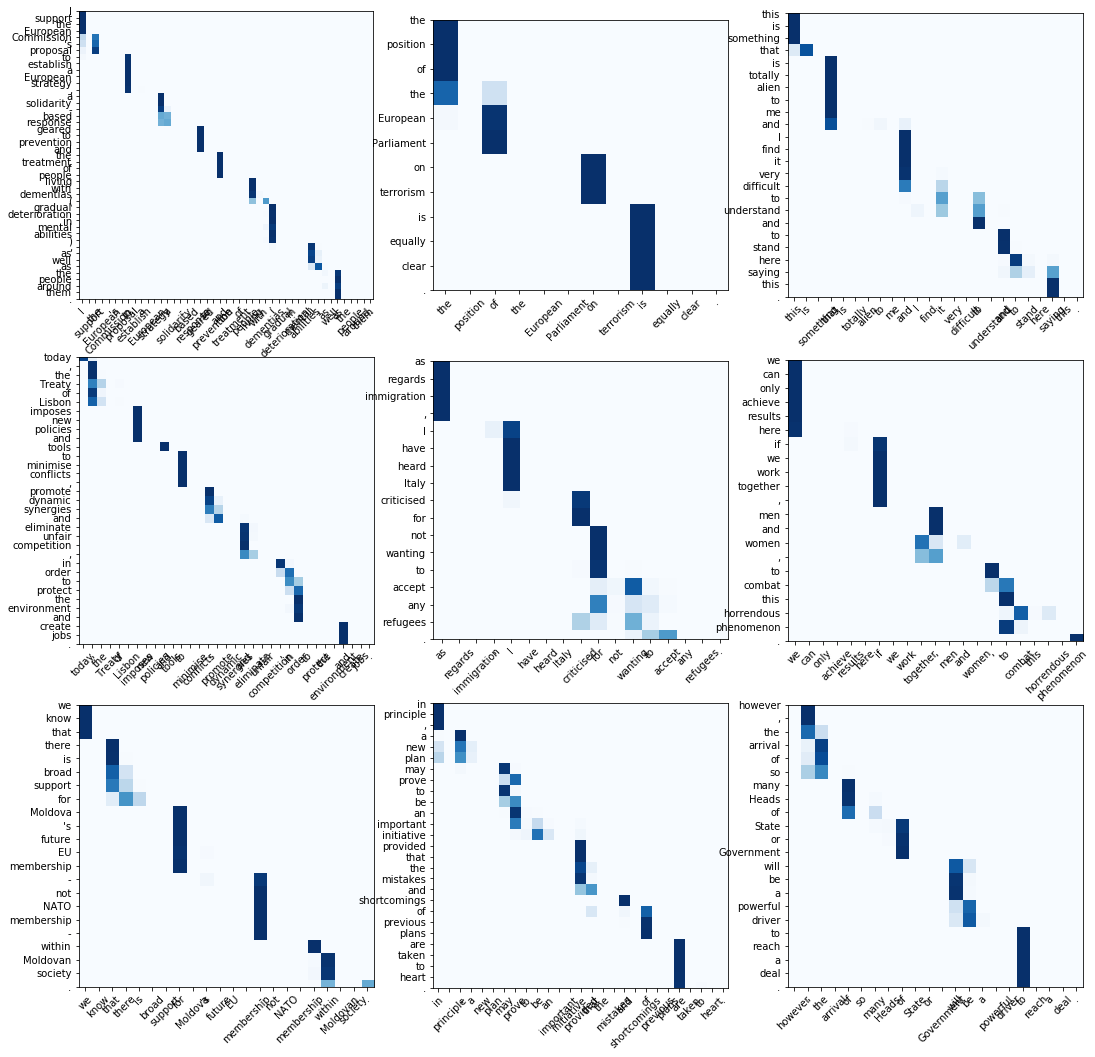

In [68]:
plot_head(viss, words_lists, 4, 9)

# L4H1 object

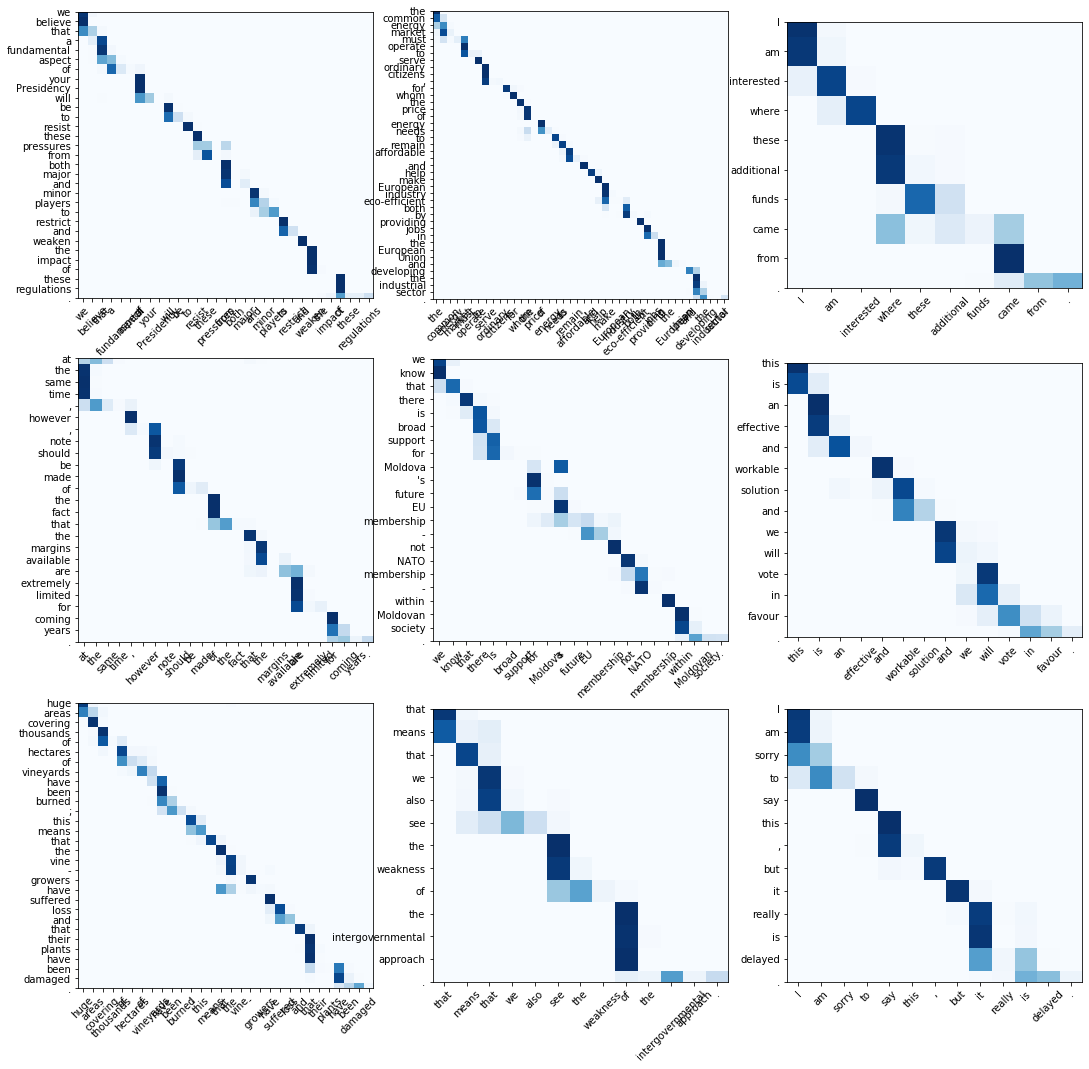

In [69]:
plot_head(viss, words_lists, 4, 1)

# L0H7 determiners modifier

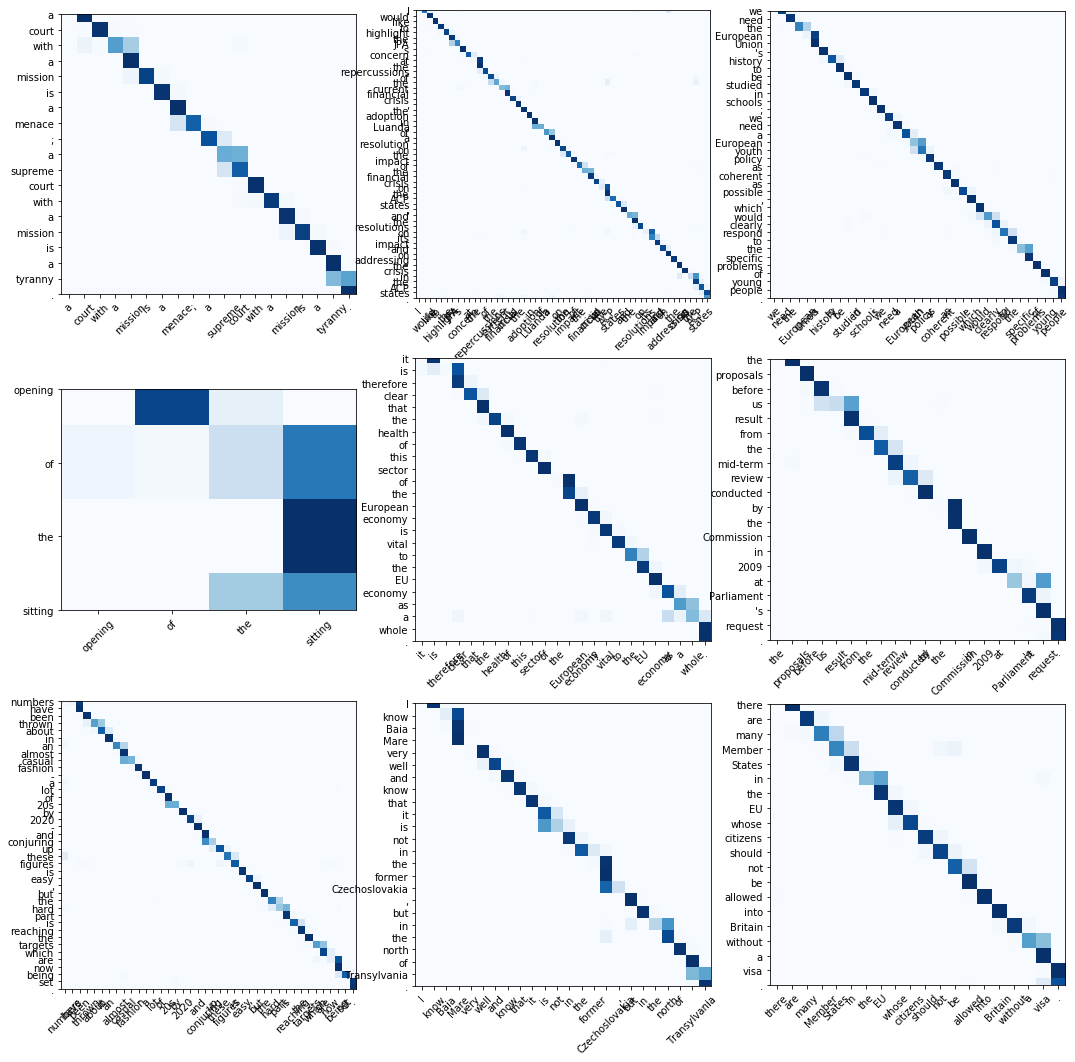

In [70]:
plot_head(viss, words_lists, 0, 7)

# L2H11 determiners

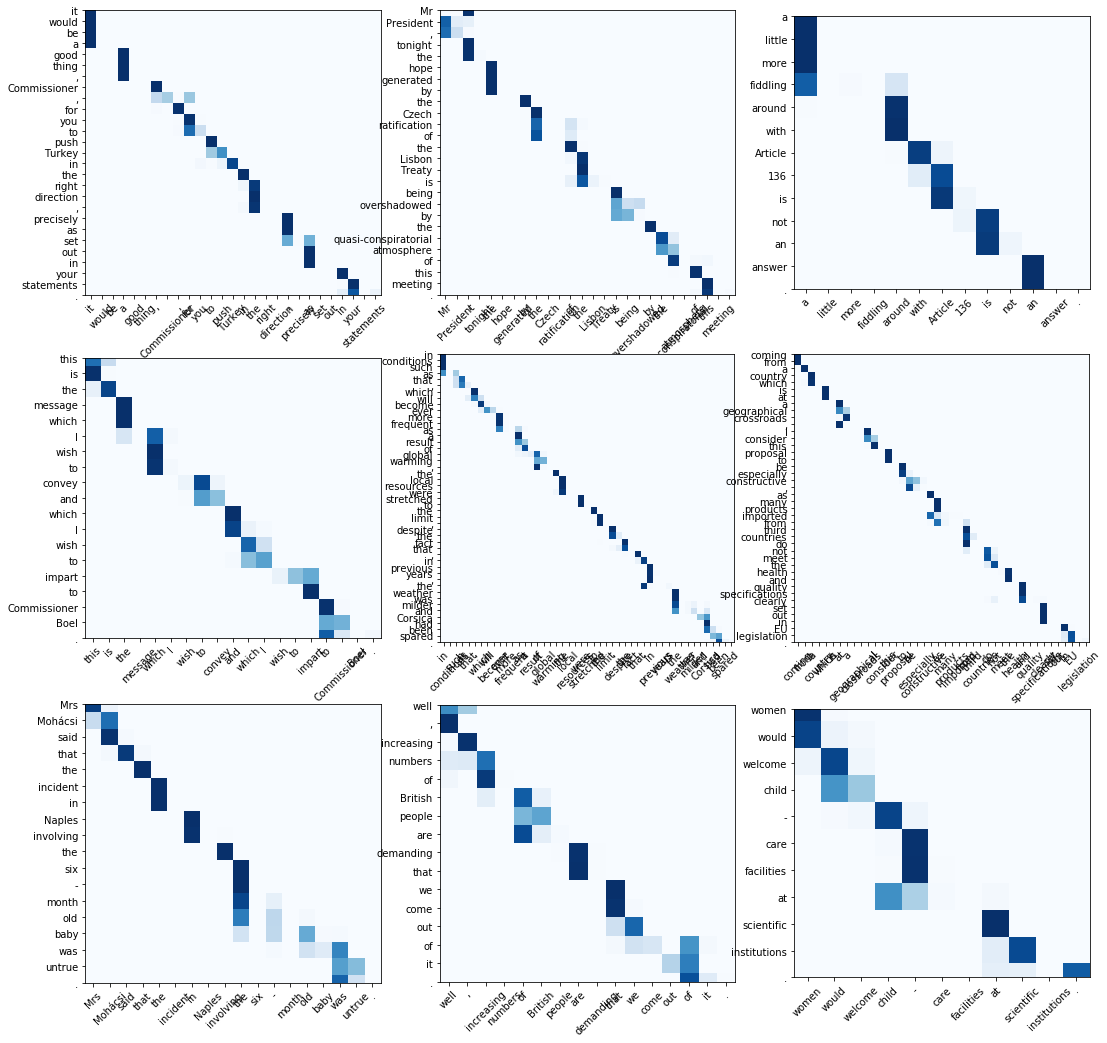

In [72]:
plot_head(viss,words_lists, 2, 11)

# L0H5 poor

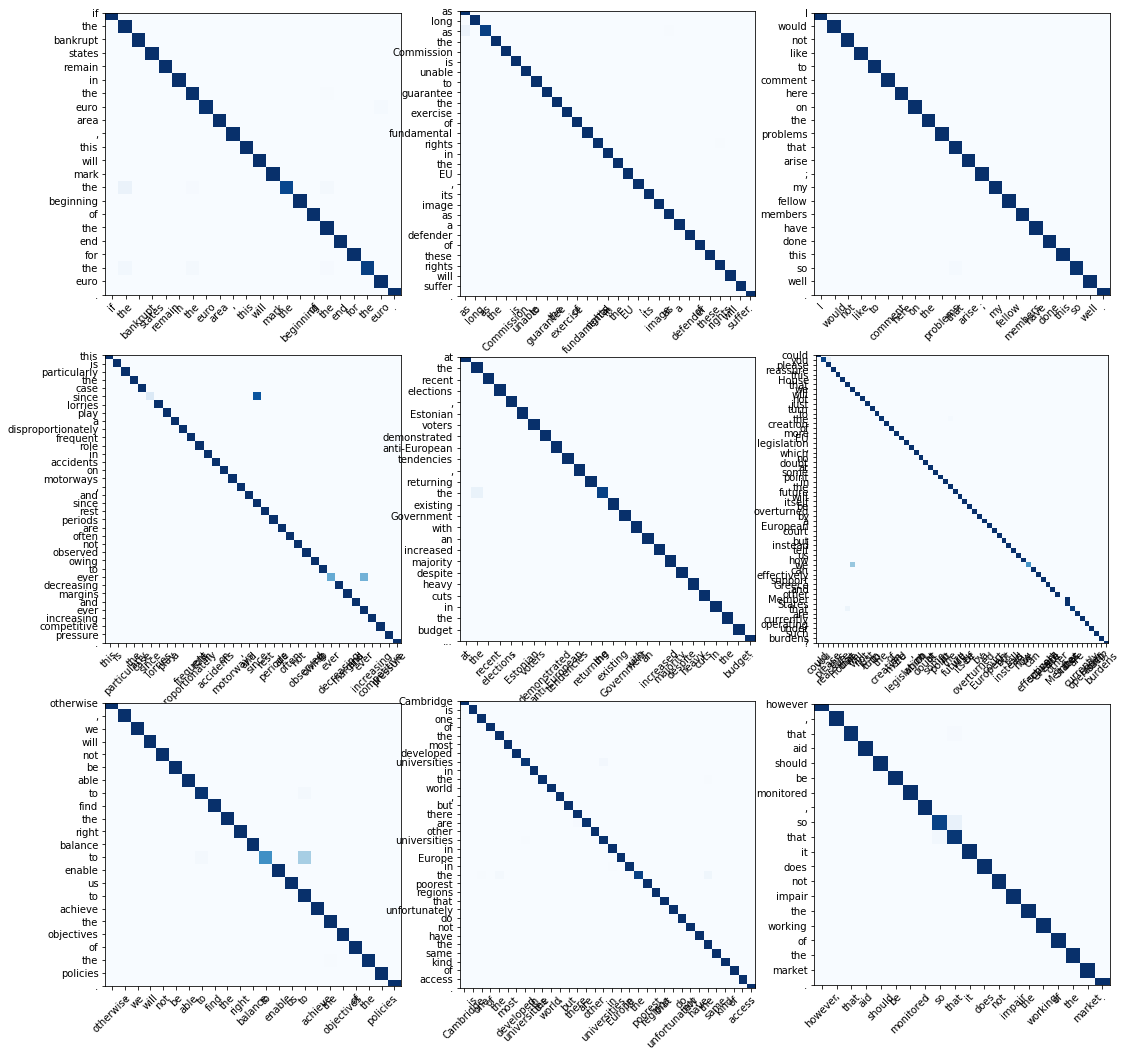

In [73]:
plot_head(viss,words_lists,  0, 5)